In [1]:
!pip install wandb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Projects/auction-classic

Mounted at /content/drive
/content/drive/MyDrive/Projects/auction-classic


In [4]:
pairs = pd.read_csv('auction_indices.csv')
pairs.head()

,record,item_id,group_len,group_mean,group_std,group_min,group_max,expansion
0,2024-01-04 00:00:00,12365,173,31.47,17.18,1.0,49.0,wotlk
1,2024-01-04 00:00:00,7462,1,49.00,0.00,49.0,49.0,wotlk
2,2024-01-04 00:00:00,20950,63,35.49,12.16,14.0,49.0,wotlk
3,2024-01-04 00:00:00,9681,23,48.00,4.91,25.0,50.0,wotlk
4,2024-01-04 00:00:00,36907,947,45.20,9.82,1.0,50.0,wotlk


## Prepare and balance data

In [5]:
pd.options.display.float_format = '{:.2f}'.format
pairs.describe()

,item_id,group_len,group_mean,group_std,group_min,group_max
count,12556735.00,12556735.00,12556735.00,12556735.00,12556735.00,12556735.00
mean,25211.34,14.34,34.36,6.42,25.85,42.76
std,17112.51,54.68,18.28,6.57,20.89,18.62
min,35.00,1.00,0.00,0.00,0.00,0.00
25%,10184.00,1.00,25.00,0.00,13.00,25.00
50%,23782.00,3.00,31.64,5.70,25.00,49.00
75%,39909.00,8.00,46.00,12.00,33.00,49.00
max,232031.00,5008.00,164.00,79.50,164.00,164.00


In [6]:
pairs = pairs[pairs['group_max'] < 50]
pairs.describe()

,item_id,group_len,group_mean,group_std,group_min,group_max
count,11657386.00,11657386.00,11657386.00,11657386.00,11657386.00,11657386.00
mean,25211.16,13.08,32.29,6.16,24.18,40.38
std,17069.72,49.82,12.17,6.29,15.46,12.61
min,35.00,1.00,0.00,0.00,0.00,0.00
25%,10214.00,1.00,24.88,0.00,13.00,25.00
50%,23827.00,3.00,31.00,5.43,25.00,49.00
75%,39682.00,8.00,44.25,11.84,26.00,49.00
max,232031.00,5008.00,49.00,24.50,49.00,49.00


In [7]:
train_pairs, val_pairs = train_test_split(pairs, test_size=0.1, random_state=42, shuffle=False)

print(f"Train pairs: {len(train_pairs)}")
print(f"Val pairs: {len(val_pairs)}")

val_pairs.head()

Train pairs: 10491647
Val pairs: 1165739


,record,item_id,group_len,group_mean,group_std,group_min,group_max,expansion
11373978,2024-08-10 15:00:00,42956,31,30.42,10.03,25.00,49.00,cata
11373979,2024-08-10 15:00:00,52149,1,49.00,0.00,49.00,49.00,cata
11373981,2024-08-10 15:00:00,45760,7,34.86,12.29,22.00,49.00,cata
11373982,2024-08-10 15:00:00,56552,4,49.00,0.00,49.00,49.00,cata
11373983,2024-08-10 15:00:00,37092,3,49.00,0.00,49.00,49.00,cata


In [8]:
train_pairs_wotlk = train_pairs[train_pairs['expansion'] == 'wotlk']

rows_to_delete = train_pairs_wotlk.sample(n=int(len(train_pairs_wotlk) * 0.85)).index
train_pairs = train_pairs.drop(rows_to_delete)

expansion
wotlk    1406526
cata     1114809
Name: count, dtype: int64


<Axes: xlabel='expansion'>

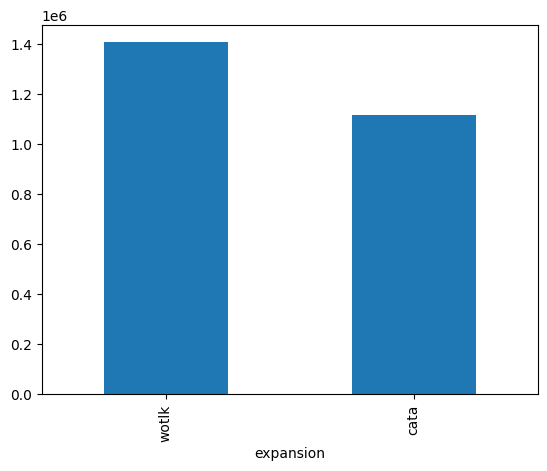

In [9]:
print(train_pairs.expansion.value_counts())

train_pairs.expansion.value_counts().plot(kind='bar')

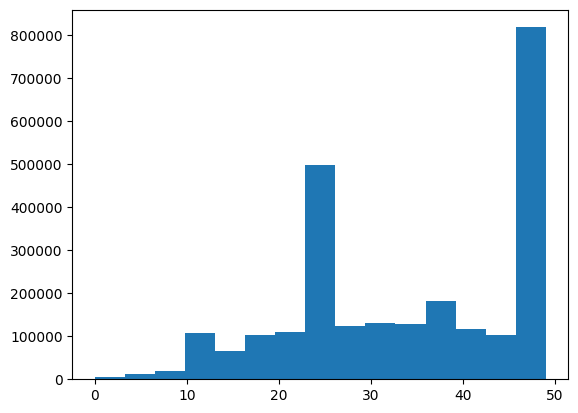

In [10]:
plt.hist(train_pairs['group_mean'], bins=15)
plt.show()

<ipython-input-11-cd5d851e07da>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(bins)


Train pairs: 1365133


<Axes: >

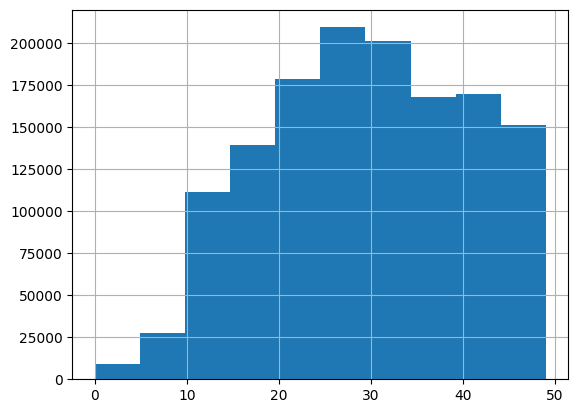

In [11]:
def uniform_sample(df, column, n_samples):
    bins = pd.cut(df[column], bins=48)

    grouped = df.groupby(bins)

    samples_per_bin = n_samples // len(grouped)
    remainder = n_samples % len(grouped)

    sampled_df = pd.DataFrame()
    for _, group in grouped:
        if len(group) > samples_per_bin:
            sample = group.sample(n=samples_per_bin, replace=False)
        else:
            sample = group
        sampled_df = pd.concat([sampled_df, sample])

    if remainder > 0:
        additional_sample = df.sample(n=remainder, replace=False)
        sampled_df = pd.concat([sampled_df, additional_sample])

    return sampled_df.sample(frac=1).reset_index(drop=True)  # Shuffle the final result

train_pairs = uniform_sample(train_pairs, 'group_mean', n_samples=int(len(train_pairs)))
print(f"Train pairs: {len(train_pairs)}")
train_pairs.group_mean.hist(bins=10)

In [12]:
train_pairs = train_pairs.sample(64)

In [13]:
items = pd.read_csv('items.csv')
n_items = len(items)

item_to_index = {item_id: i + 2 for i, item_id in enumerate(items['item_id'])}
item_to_index[0] = 0 # padding
item_to_index[1] = 1 # unknown
n_items

11655

## Preprocess data

In [14]:
import torch
from datetime import datetime

class AuctionDataset(torch.utils.data.Dataset):

    def __init__(self, pairs, item_to_index, path='sequences'):
        self.pairs = pairs
        self.column_map = {
            'bid': 0,
            'buyout': 1,
            'quantity': 2,
            'item_id': 3,
            'time_left': 4,
            'hours_since_first_appearance': 5
        }
        self.item_to_index = item_to_index
        self.path = path

        print(f"Dataset size: {len(self)}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs.iloc[idx]

        record = pair['record']
        item_id = pair['item_id']

        # Parse the record timestamp
        date_time_obj = datetime.strptime(record, "%Y-%m-%d %H:%M:%S")
        date_folder_name = date_time_obj.strftime("%Y-%m-%d")
        hour_folder_name = date_time_obj.strftime("%H")

        file_path = f'{self.path}/{date_folder_name}/{hour_folder_name}.pt'

        data = torch.load(file_path)
        X = torch.tensor(data[item_id])

        y = X[:, -1]
        X = X[:, :-1]

        X[:, self.column_map['item_id']] = torch.tensor([self.item_to_index.get(int(item), 1) for item in X[:, self.column_map['item_id']]], dtype=torch.long)
        X[:, self.column_map['time_left']] = X[:, self.column_map['time_left']] / 48.0
        X[:, self.column_map['hours_since_first_appearance']] = X[:, self.column_map['hours_since_first_appearance']] / 48.0
        X[:, self.column_map['bid']] = torch.log1p(X[:, self.column_map['bid']]) / 15.0
        X[:, self.column_map['buyout']] = torch.log1p(X[:, self.column_map['buyout']]) / 15.0
        X[:, self.column_map['quantity']] = X[:, self.column_map['quantity']] / 200.0

        return X, y

In [15]:
def collate_auctions(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    X, y = zip(*batch)

    lengths = torch.LongTensor([x.size(0) for x in X])

    max_length = lengths.max()

    X = [F.pad(x, (0, 0, 0, max_length - x.size(0))) for x in X]
    y = [F.pad(x, (0, max_length - x.size(0))) for x in y]

    X = torch.stack(X)
    y = torch.stack(y)

    return X, y, lengths

## Model definition

In [16]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):

    def __init__(self, input_size=5, item_index=3, embedding_size=16, hidden_size=16, dropout_p=0.1, bidirectional=True):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.item_index = item_index
        n_items = len(item_to_index)

        self.embedding = nn.Embedding(n_items, embedding_size)
        self.rnn = nn.LSTM(input_size + embedding_size, hidden_size, batch_first=True, num_layers=2, bidirectional=bidirectional, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, X, lengths):
        item_ids = X[:, :, self.item_index].long()
        X = torch.cat([X[:, :, :self.item_index], X[:, :, self.item_index + 1:]], dim=2)
        item_embeddings = self.dropout(self.embedding(item_ids))

        X = torch.cat([X, item_embeddings], dim=2)
        X_packed = pack_padded_sequence(X, lengths, batch_first=True, enforce_sorted=False)

        output_packed, (hidden, cell) = self.rnn(X_packed)

        return output_packed, (hidden, cell)


class Decoder(nn.Module):

    def __init__(self, input_size, hidden_size, bidirectional=True, dropout_p=0.1):
        super(Decoder, self).__init__()
        output_size = hidden_size * 2 if bidirectional else hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, bidirectional=bidirectional, dropout=dropout_p)
        self.projection = nn.Sequential(
            nn.Linear(output_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, encoder_outputs, encoder_hidden):
        output_packed, _ = self.rnn(encoder_outputs, encoder_hidden)

        output, _ = pad_packed_sequence(output_packed, batch_first=True)
        output = self.projection(output)

        return output


class AuctionPredictor(nn.Module):
    def __init__(self, input_size=5, encoder_hidden_size=16, decoder_hidden_size=16, item_index=3, embedding_size=16, dropout_p=0.1, bidirectional=True):
        super(AuctionPredictor, self).__init__()
        decoder_input_size = encoder_hidden_size * 2 if bidirectional else encoder_hidden_size
        self.encoder = Encoder(input_size, item_index, embedding_size, encoder_hidden_size, dropout_p, bidirectional=bidirectional)
        self.decoder = Decoder(decoder_input_size, decoder_hidden_size, bidirectional=bidirectional, dropout_p=dropout_p)

    def forward(self, X, lengths):
        encoder_outputs, encoder_hidden = self.encoder(X, lengths)
        decoder_outputs = self.decoder(encoder_outputs, encoder_hidden)
        return decoder_outputs

In [17]:
train_dataset = AuctionDataset(train_pairs, item_to_index)
val_dataset = AuctionDataset(val_pairs, item_to_index)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_auctions, num_workers=2, prefetch_factor=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, collate_fn=collate_auctions, num_workers=2, prefetch_factor=8)

Dataset size: 64
Dataset size: 1165739


In [18]:
embedding_size = 128
encoder_hidden_size = 256
decoder_hidden_size = 256
epochs = 50000
save_every_iters = 2500

model = AuctionPredictor(input_size=5,
                         encoder_hidden_size=encoder_hidden_size,
                         decoder_hidden_size=decoder_hidden_size,
                         item_index=3,
                         embedding_size=embedding_size,
                         dropout_p=0.0,
                         bidirectional=False
                         ).to(device)

print(sum(p.numel() for p in model.parameters()))

load_checkpoint = False

if load_checkpoint:
  checkpoint = torch.load('checkpoints/checkpoint_epoch_4.pt')
  model.load_state_dict(checkpoint['model_state_dict'])

#optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
total_steps = len(train_dataloader) * epochs
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)
criterion = nn.MSELoss(reduction='sum')

print(f'Iterations per epoch: {len(train_dataloader)}')

3490049
Iterations per epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
enable_logging = True

if enable_logging:
  print("Logging enabled")
  wandb.init(project="auction-classic", config={
      "epochs": epochs,
      "batch_size": train_dataloader.batch_size,
      "learning_rate": optimizer.param_groups[0]['lr'],
      "encoder_hidden_size": encoder_hidden_size,
      "decoder_hidden_size": decoder_hidden_size,
      "model_size": sum(p.numel() for p in model.parameters()),
      "embedding_size": embedding_size,
      "bidirectional": False,
      "dropout": 0.2
  })
else:
  print("Logging disabled")
  wandb.init(mode="disabled")

Logging enabled


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Training

In [ ]:
def save_checkpoint(model, optimizer, epoch, iters, checkpoint_path='checkpoints'):
    os.makedirs(checkpoint_path, exist_ok=True)
    checkpoint_file = os.path.join(checkpoint_path, f"checkpoint_epoch_{epoch}_iter_{iters}.pt")
    torch.save({
        'epoch': epoch,
        'iter': iters,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_file)
    print(f"Checkpoint saved at {checkpoint_file}")

def train(
    model,
    train_loader,
    val_loader,
    epochs,
    eval_steps,
    device,
    optimizer,
    criterion,
    lr_scheduler
):
    print("Starting training for", epochs, "epochs")

    for epoch in tqdm(range(epochs)):
        model.train()

        mse_losses = []
        mae_losses = []

        for i, (X, y, lengths) in enumerate(tqdm(train_loader, total=len(train_loader))):
            X = X.to(device)
            y = y.to(device)

            y_pred = model(X, lengths)
            mask = (y != 0).float().unsqueeze(2)

            loss = criterion(y_pred * mask, y.unsqueeze(2)) / mask.sum()
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
            optimizer.step()
            lr_scheduler.step(loss.item())
            optimizer.zero_grad()

            with torch.no_grad():
                mae = F.l1_loss(y_pred * mask, y.unsqueeze(2) * mask, reduction='sum') / mask.sum()

            mse_losses.append(loss.item())
            mae_losses.append(mae.item())

            if i % 50 == 0:
                mse_loss_avg = np.mean(mse_losses)
                mae_loss_avg = np.mean(mae_losses)
                lr = lr_scheduler.get_last_lr()[0]
                print(f"Epoch {epoch} Iteration {i} Loss {mse_loss_avg} MAE {mae_loss_avg} LR {lr}")

                wandb.log({
                  "train/mse_loss": mse_loss_avg,
                  "train/mae_loss": mae_loss_avg,
                  "train/learning_rate": lr,
                  "epoch": epoch,
                  "iter": i
                })

                mse_losses = []
                mae_losses = []

            if (i + 1) % eval_steps == 0:
              val_loss, val_mae = evaluate(model, val_loader, device, criterion)
              wandb.log({
                "val/mse_loss": val_loss,
                "val/mae_loss": val_mae,
                "epoch": epoch
              })

            if (i + 1) % save_every_iters == 0:
              save_checkpoint(model, optimizer, epoch, i)

        #save_checkpoint(model, optimizer, epoch, len(train_loader))

    wandb.finish()

@torch.no_grad()
def evaluate(
    model,
    val_loader,
    device,
    criterion
):
    print("Evaluating model")
    model.eval()

    mse_losses = []
    mae_losses = []

    for i, (X, y, lengths) in enumerate(val_loader):

      if i >= 500:
        break

      if i % 15 == 0:
        print(f"Evaluating step {i}")

      X = X.to(device)
      y = y.to(device)

      y_pred = model(X, lengths)

      mask = (y != 0).float().unsqueeze(2)
      loss = criterion(y_pred * mask, y.unsqueeze(2)) / mask.sum()
      mae = F.l1_loss(y_pred * mask, y.unsqueeze(2) * mask, reduction='sum') / mask.sum()

      mse_losses.append(loss.item())
      mae_losses.append(mae.item())

      if i % 25 == 0:
        print(f"Evaluating step {i}")
        print(y[0][:10])
        print(y_pred[0,:, 0][:10])

    mse_loss_avg = np.mean(mse_losses)
    mae_loss_avg = np.mean(mae_losses)

    print(f"Validation loss: {mse_loss_avg} MAE: {mae_loss_avg}")
    model.train()

    return mse_loss_avg, mae_loss_avg

train(
    model,
    train_dataloader,
    val_dataloader,
    epochs,
    eval_steps=250,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    lr_scheduler=lr_scheduler
)

Starting training for 50000 epochs


  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 1/50000

Epoch 0 Iteration 0 Loss 963.443603515625 MAE 26.573089599609375 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 2/5000

Epoch 1 Iteration 0 Loss 959.97021484375 MAE 26.507619857788086 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 3/5000

Epoch 2 Iteration 0 Loss 956.5707397460938 MAE 26.443391799926758 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 4/5000

Epoch 3 Iteration 0 Loss 953.2449951171875 MAE 26.380420684814453 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 5/5000

Epoch 4 Iteration 0 Loss 949.9349975585938 MAE 26.317594528198242 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 6/5000

Epoch 5 Iteration 0 Loss 946.6167602539062 MAE 26.25445556640625 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 7/5000

Epoch 6 Iteration 0 Loss 943.308837890625 MAE 26.191373825073242 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 8/5000

Epoch 7 Iteration 0 Loss 939.9910888671875 MAE 26.12791633605957 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 9/5000

Epoch 8 Iteration 0 Loss 936.635009765625 MAE 26.063581466674805 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 10/500

Epoch 9 Iteration 0 Loss 933.2427978515625 MAE 25.99842071533203 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 11/500

Epoch 10 Iteration 0 Loss 929.8089599609375 MAE 25.932279586791992 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 12/500

Epoch 11 Iteration 0 Loss 926.3237915039062 MAE 25.864959716796875 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 13/500

Epoch 12 Iteration 0 Loss 922.7852783203125 MAE 25.796422958374023 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 14/500

Epoch 13 Iteration 0 Loss 919.2089233398438 MAE 25.72699737548828 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 15/500

Epoch 14 Iteration 0 Loss 915.5513305664062 MAE 25.655797958374023 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 16/500

Epoch 15 Iteration 0 Loss 911.7981567382812 MAE 25.584474563598633 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 17/500

Epoch 16 Iteration 0 Loss 907.9358520507812 MAE 25.51353645324707 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 18/500

Epoch 17 Iteration 0 Loss 903.9492797851562 MAE 25.440093994140625 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 19/500

Epoch 18 Iteration 0 Loss 899.8220825195312 MAE 25.363819122314453 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 20/500

Epoch 19 Iteration 0 Loss 895.535888671875 MAE 25.284339904785156 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 21/500

Epoch 20 Iteration 0 Loss 891.0693969726562 MAE 25.201234817504883 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 22/500

Epoch 21 Iteration 0 Loss 886.4010620117188 MAE 25.114046096801758 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 23/500

Epoch 22 Iteration 0 Loss 881.5056762695312 MAE 25.02226448059082 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 24/500

Epoch 23 Iteration 0 Loss 876.3532104492188 MAE 24.925273895263672 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 25/500

Epoch 24 Iteration 0 Loss 870.9008178710938 MAE 24.82219886779785 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 26/500

Epoch 25 Iteration 0 Loss 865.1171264648438 MAE 24.712352752685547 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 27/500

Epoch 26 Iteration 0 Loss 858.947509765625 MAE 24.598657608032227 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 28/500

Epoch 27 Iteration 0 Loss 852.3414306640625 MAE 24.478046417236328 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 29/500

Epoch 28 Iteration 0 Loss 845.2351684570312 MAE 24.3475399017334 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 30/500

Epoch 29 Iteration 0 Loss 837.5513305664062 MAE 24.20553207397461 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 31/500

Epoch 30 Iteration 0 Loss 829.2093505859375 MAE 24.050260543823242 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 32/500

Epoch 31 Iteration 0 Loss 820.0911254882812 MAE 23.879240036010742 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 33/500

Epoch 32 Iteration 0 Loss 810.0843505859375 MAE 23.69304656982422 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 34/500

Epoch 33 Iteration 0 Loss 799.0278930664062 MAE 23.48870086669922 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 35/500

Epoch 34 Iteration 0 Loss 786.7467041015625 MAE 23.25921630859375 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 36/500

Epoch 35 Iteration 0 Loss 773.013671875 MAE 22.9993896484375 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 37/500

Epoch 36 Iteration 0 Loss 757.5558471679688 MAE 22.70621681213379 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 38/500

Epoch 37 Iteration 0 Loss 740.0479125976562 MAE 22.370161056518555 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 39/500

Epoch 38 Iteration 0 Loss 720.0706787109375 MAE 21.98038101196289 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 40/500

Epoch 39 Iteration 0 Loss 697.123046875 MAE 21.528961181640625 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 41/500

Epoch 40 Iteration 0 Loss 670.6393432617188 MAE 20.99570655822754 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 42/500

Epoch 41 Iteration 0 Loss 639.96337890625 MAE 20.35967254638672 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 43/500

Epoch 42 Iteration 0 Loss 604.4115600585938 MAE 19.595806121826172 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 44/500

Epoch 43 Iteration 0 Loss 563.405029296875 MAE 18.668113708496094 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 45/500

Epoch 44 Iteration 0 Loss 516.7289428710938 MAE 17.53415870666504 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 46/500

Epoch 45 Iteration 0 Loss 464.9654235839844 MAE 16.161252975463867 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 47/500

Epoch 46 Iteration 0 Loss 410.7109375 MAE 15.370283126831055 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 48/500

Epoch 47 Iteration 0 Loss 358.9736022949219 MAE 14.808903694152832 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 49/500

Epoch 48 Iteration 0 Loss 316.67425537109375 MAE 14.223085403442383 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 50/500

Epoch 49 Iteration 0 Loss 289.2744140625 MAE 13.720259666442871 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 51/500

Epoch 50 Iteration 0 Loss 276.1942138671875 MAE 13.355398178100586 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 52/500

Epoch 51 Iteration 0 Loss 271.4397888183594 MAE 13.383328437805176 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)

  0%|          | 53/500

Epoch 52 Iteration 0 Loss 269.6177062988281 MAE 13.499499320983887 LR 0.001



  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-14-c21f3e9ec0b3>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


In [ ]:
wandb.finish()

## Inference

In [ ]:
torch.set_printoptions(sci_mode=False)

In [ ]:
X[:, val_dataset.column_map['bid']] = X[:, val_dataset.column_map['bid']] / 1000
X[:, val_dataset.column_map['buyout']] = X[:, val_dataset.column_map['buyout']] / 1000

print(X)

pred = model(X.unsqueeze(0).to('cpu'))

X[:, val_dataset.column_map['bid']] = X[:, val_dataset.column_map['bid']] * 1000
X[:, val_dataset.column_map['buyout']] = X[:, val_dataset.column_map['buyout']] * 1000
X[:, val_dataset.column_map['quantity']] = X[:, val_dataset.column_map['quantity']] * 200
X[:, val_dataset.column_map['hours_since_first_appearance']] = X[:, val_dataset.column_map['hours_since_first_appearance']] * 48
X[:, val_dataset.column_map['time_left']] = X[:, val_dataset.column_map['time_left']] * 48

print(X)
print(y)

print(pred)

In [ ]:
index_to_item = {i + 2: item_id for i, item_id in enumerate(items['item_id'])}
index_to_item[0] = 0
index_to_item[1] = 1

print(index_to_item.get(7631))